In [3]:
# Variational Autoencoder (VAE) model
# Using torch
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable

# 데이터 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
])

# MNIST 데이터셋 다운로드 및 로드
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)


In [4]:
class VAE(nn.Module):
    def __init__(self, z_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.ReLU(),
            nn.Linear(400, z_dim*2)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 28*28),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        h = self.encoder(x.view(-1, 28*28))
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

z_dim = 20
model = VAE(z_dim).cuda()  # GPU를 사용하기 위해 .cuda() 사용


In [5]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [7]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

for epoch in range(1, 11):
    train(epoch)


Train Epoch: 1 [0/60000 (0%)]	Loss: 116.200172
Train Epoch: 1 [3200/60000 (5%)]	Loss: 114.029564
Train Epoch: 1 [6400/60000 (11%)]	Loss: 109.519005
Train Epoch: 1 [9600/60000 (16%)]	Loss: 117.712326
Train Epoch: 1 [12800/60000 (21%)]	Loss: 109.574867
Train Epoch: 1 [16000/60000 (27%)]	Loss: 118.219536
Train Epoch: 1 [19200/60000 (32%)]	Loss: 115.299538
Train Epoch: 1 [22400/60000 (37%)]	Loss: 110.358704
Train Epoch: 1 [25600/60000 (43%)]	Loss: 109.367722
Train Epoch: 1 [28800/60000 (48%)]	Loss: 109.122284


KeyboardInterrupt: 

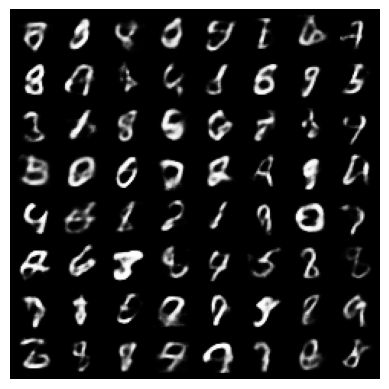

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 
model.eval()
with torch.no_grad():
    sample = torch.randn(64, z_dim).cuda()
    sample = model.decoder(sample).cpu()

    def imshow(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')
        plt.show()

    imshow(torchvision.utils.make_grid(sample.view(64, 1, 28, 28)))


In [11]:
from telegram.jskang import Telebot_jskang

bot = Telebot_jskang()
bot.send_message('VAE model is trained!')

RuntimeError: asyncio.run() cannot be called from a running event loop